# Imports 

In [1]:
import ipynb.fs.full.PrepareData as data
from sklearn.multioutput import MultiOutputRegressor
import itertools

strategyArray = []
errorArray    = [[], []]

/home/leandro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
  9%|▉         | 4/43 [00:00<00:01, 38.34it/s]

[104, 779, 214, 307, 262, 294, 1154, 1105, 770, 1126, 728, 1125, 924]
2 chs: 104 entries
3 chs: 779 entries
4 chs: 214 entries
5 chs: 307 entries
6 chs: 262 entries
7 chs: 294 entries
8 chs: 1154 entries
9 chs: 1105 entries
10 chs: 770 entries
15 chs: 1126 entries
20 chs: 728 entries
30 chs: 1125 entries
40 chs: 924 entries


 88%|████████▊ | 38/43 [00:08<00:00,  5.60it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 26%|██▌       | 11/43 [00:00<00:02, 13.21it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 91%|█████████ | 39/43 [00:07<00:00,  5.82it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 88%|████████▊ | 38/43 [00:08<00:01,  4.72it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 26%|██▌       | 11/43 [00:00<00:02, 13.12it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 91%|█████████ | 39/43 [00:06<00:00,  5.86it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 74%|███████▍  | 32/43 [00:06<00:02,  4.89it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 91%|█████████ | 39/43 [00:07<00:00,  7.30it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 26%|██▌       | 11/43 [00:01<00:04,  7.06it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 77%|███████▋  | 33/43 [00:05<00:01,  8.16it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 88%|████████▊ | 38/43 [00:06<00:00, 10.62it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:06<00:00,  6.64it/s]


# Sorting the dataset

In [2]:
sortedDict = {}
commonRegressors = data.commonRegressors

for regressor in commonRegressors:
    sortedDict[regressor] = 0
    
    for i in range(data.ampNumber):
        sortedDict[regressor] += data.finalList[i][regressor][0] + data.finalList[i][regressor][1]

sortedDict = dict(sorted(sortedDict.items(), key = lambda x : x[1]))
sortedDict = dict(itertools.islice(sortedDict.items(), 5))

print(sortedDict.keys())

dict_keys(['BaggingRegressor', 'RandomForestRegressor', 'XGBRegressor', 'DecisionTreeRegressor', 'TransformedTargetRegressor'])


# Processing data

In [3]:
from sklearn.metrics import mean_absolute_error

def getMAE(yTrue, yPredicted):
    gainErrors = []
    lossErrors = []
    
    rangeList = list(range(len(yTrue[0])))
    
    for true, predicted in zip(yTrue, yPredicted):
        gainTrue      = [true[x] for x in rangeList[0::2]]
        gainPredicted = [predicted[x] for x in rangeList[0::2]]
        lossTrue      = [true[x] for x in rangeList[1::2]]
        lossPredicted = [predicted[x] for x in rangeList[1::2]]
        
        gainErrors.append(mean_absolute_error(gainTrue, gainPredicted))
        lossErrors.append(mean_absolute_error(lossTrue, lossPredicted))
        
    return gainErrors, lossErrors

# Plotting function

In [4]:
import matplotlib.pyplot as plt

def plotGrid(gainData, lossData):
    fig, axis = plt.subplots(2, figsize = (12, 8))
    fig.suptitle('One regressor per variable', fontsize = 16)
    
    axis[0].boxplot(gainData)
    axis[0].set_title("Gain test error")
    
    axis[1].boxplot(lossData)
    axis[1].set_title("Loss test error")
    
    fig.text(0.09, 0.5, 'Mean Absolute error (dB)', va='center', rotation='vertical', fontsize = 14)
    fig.legend(strategyArray, handlelength = 0, loc = "upper right")
    fig.savefig("PerVar-{}amps".format(data.ampNumber))

# Building the models

In [5]:
X, y = data.loadDataset()
X_train, X_test, y_train, y_test = data.train_test_split(X, y, test_size = 0.3, random_state = 0)

count = 1

In [6]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    extra_tree = ExtraTreeRegressor(criterion = "mse", random_state = 0)
    model      = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, 
                                                       n_estimators   = 100,
                                                       random_state   = 0))

    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))
    
print(finalY[0], finalResult[0])

strategyArray.append("{} - BaggingRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1

[22.  9. 23.  3. 24.  1.] [23.82373686  2.92234628 18.73668037  7.92186194 23.84548757  0.19247616]


In [7]:
from sklearn.ensemble import RandomForestRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(RandomForestRegressor())
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))
    
print(finalY[0], finalResult[0])

strategyArray.append("{} - RandomForestRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1

[22.  9. 23.  3. 24.  1.] [23.82897548  2.96152728 18.8225699   7.93875425 23.84553391  0.18917981]


In [8]:
from xgboost import XGBRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(XGBRegressor())
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))
    
print(finalY[0], finalResult[0])

strategyArray.append("{} - XGBRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1

[22.  9. 23.  3. 24.  1.] [23.82826     2.9062517  18.703043    7.9218435  23.843761    0.18737616]


In [9]:
from sklearn.tree import DecisionTreeRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(DecisionTreeRegressor())
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))
    
print(finalY[0], finalResult[0])

strategyArray.append("{} - DecisionTreeRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1

[22.  9. 23.  3. 24.  1.] [23.828125  2.90625  18.703125  7.921875 23.84375   0.1875  ]


In [10]:
from sklearn.compose import TransformedTargetRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(TransformedTargetRegressor())
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))
    
print(finalY[0], finalResult[0])

strategyArray.append("{} - TransformedTargetRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1

[22.  9. 23.  3. 24.  1.] [23.83648682  2.91674805 18.71777344  7.9246521  23.8409462   0.18540192]


In [11]:
from sklearn.dummy import DummyRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(DummyRegressor())
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))
    
print(finalY[0], finalResult[0])

strategyArray.append("{} - DummyRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1

[22.  9. 23.  3. 24.  1.] [22.09830867  4.71458774 19.8435518   5.71987315 23.43234672  0.17547569]


dict_keys(['BaggingRegressor', 'RandomForestRegressor', 'XGBRegressor', 'DecisionTreeRegressor', 'TransformedTargetRegressor'])


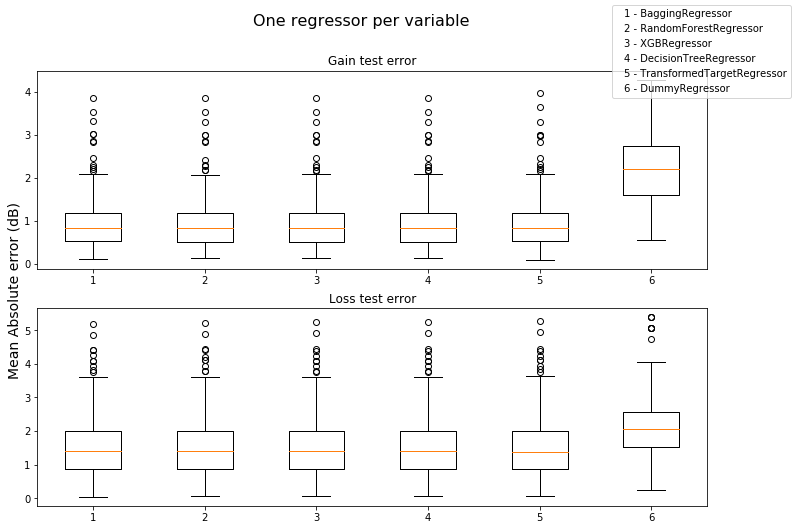

In [12]:
print(sortedDict.keys())
plotGrid(errorArray[0], errorArray[1])